<a href="https://colab.research.google.com/github/N0taName/NN-with-PSO-/blob/main/PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing Neural Network Classification Accuracy with Particle Swarm Optimization

## PSO implementation

In [1]:
! pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 55.6 kB/s eta 0:00:00m eta 0:00:010:00:01


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import copy
import matplotlib
from matplotlib import pyplot as plt
import torchmetrics
from torchmetrics import Accuracy
import numpy as np
import pandas as pd

/tmp/ipykernel_66779/520347315.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def create_velocity(model):
  """
  Returns random velocity for the particle
  Args:
    model: The model which will be trained
  Returns:
    velocity: randomly initialized list of tensors with tensors of model layers shapes
  """
  velocity = []
  for m in model:
    if isinstance(m, nn.Linear):
      velocity.append(torch.rand_like(m.weight))
  return velocity

In [4]:
def update_velocity(model,velocity,global_best,local_best,alpha=1,beta=1,theta=0.7):
  """
  Returns updated velocity for the particle
  Args:
    model: the model which will be trained
    velocity: the curent particle velocity
    global_best: the paritcles` postion with the best metric
    local_best: the paritcle`s with the best metric
    alpha: float number, represents how paritcle tends to global_best postion
    beta: float number, represents how paritcle tends to local_best postion
    theta: float number, represents inertia parameter
  Returns:
    new_velocity: a list of tensors with tensors of model layers shapes
  """
  new_velocity = []
  j=0
  for i in range(len(model)):
    if isinstance(model[i], nn.Linear):
      new_velocity.append(theta*velocity[j]+alpha*np.random.rand()*(global_best[i].weight-model[i].weight)+np.random.rand()*beta*(local_best[i].weight-model[i].weight))
      j+=1
  return new_velocity

In [5]:
def update_position(model,velocity):
  """
  Returns updated position for the particle
  Args:
    model: the particle which will be trained
    velocity: the curent particle velocity
  Returns:
    model
  """
  j=0
  for i in range(len(model)):
    if isinstance(model[i], nn.Linear):
      model[i].weight = nn.Parameter(model[i].weight+velocity[j])
      j+=1
  return model

In [6]:
def create_particle(model):
  """
  Returns updated position for the particle
  Args:
    model: the particle which will be trained
    velocity: the curent particle velocity
  Returns:
    model
  """
  new_model = copy.deepcopy(model)
  for i in range(len(new_model)):
    if isinstance(new_model[i], nn.Linear):
      nn.init.uniform_(new_model[i].weight,a=-1,b=1)
  return new_model

In [7]:
def train(model,metric,data,labels,iterations=100,n_particles=50,alpha=1,beta=1,theta_function=lambda iter: 0.7,minim=True,rand_seed=42):
  """
  Returns updated position for the particle
  Args:
    model: the particle which will be trained
    metric: the curent particle velocity
    data: features
    labels: targets
    iterations: number of iterations
    n_particles: number of particles
    alpha: float number, represents how paritcle tends to global_best postion
    beta: float number, represents how paritcle tends to local_best postion
    theta_function: function that takes curent iteration and returns inertia
    minim: True if solving minimisation, False if maximisation
    rand_seed: random seed
  Returns:
    global_best: model with the best performance
    history: history of particles results
    global_best_hist: history of global_best results
  """
  np.random.seed(rand_seed)
  particles = [create_particle(model) for _ in range(n_particles)]
  global_best = None
  global_best_y = None
  global_best_hist=[]
  local_bests = [None for _ in range(n_particles)]
  local_bests_y = [None for _ in range(n_particles)]
  velocities = [create_velocity(model) for _ in range(n_particles) ]
  history = []
  for iter in tqdm.tqdm(range(iterations)):
    results = [metric(particles[i](data),labels).detach().numpy().item() for i in range(n_particles)]
    for i in range(n_particles):
      if global_best_y is None or (global_best_y > results[i] and minim) or (global_best_y < results[i] and not minim):
        global_best_y = results[i]
        global_best = copy.deepcopy(particles[i])
      if local_bests_y[i] is None or (local_bests_y[i] > results[i] and minim) or (local_bests_y[i] < results[i] and not minim):
        local_bests_y[i] = results[i]
        local_bests[i] = copy.deepcopy(particles[i])
    for i in range(n_particles):
      particles[i] = update_position(particles[i],velocities[i])
      velocities[i] = update_velocity(particles[i],velocities[i],global_best,local_bests[i],alpha=alpha,beta=beta,theta=theta_function(iter))
    history.append(copy.deepcopy(results))
    #print(results)
    global_best_hist.append(global_best_y)
  return global_best,pd.DataFrame(history),global_best_hist

## Testing on Fashion Mnist

In [8]:
import torchvision
from torchvision import transforms

transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,)),
      transforms.ConvertImageDtype(dtype=torch.float32)
    ])

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [9]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,128,dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(128,64,dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(64,10,dtype=torch.float32),
    nn.Softmax(1)
)

In [10]:
training_set.data = training_set.data.type(torch.float32)

In [11]:
validation_set.data = validation_set.data.type(torch.float32)

### PSO

In [12]:
best_model,history,global_best_history = train(
    model=model,
    metric=Accuracy(task="multiclass", num_classes=len(classes)),
    data=training_set.data,
    labels=training_set.targets,
    iterations=100,n_particles=20,alpha=4,beta=4,minim=False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


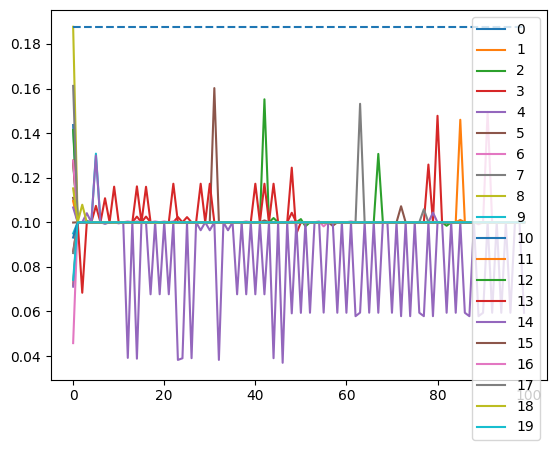

In [13]:
history.plot()
plt.plot(global_best_history,'--')
plt.show()

In [14]:
from sklearn import metrics

y_pred = best_model(validation_set.data)
tmp = [torch.argmax(y_pred[i]) for i in range(len(y_pred))]

print(metrics.classification_report(validation_set.targets.detach().numpy(),tmp,target_names=classes,zero_division=0))

              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00      1000
     Trouser       0.09      0.14      0.11      1000
    Pullover       0.10      0.00      0.00      1000
       Dress       0.05      0.00      0.00      1000
        Coat       0.32      0.12      0.17      1000
      Sandal       0.12      0.35      0.18      1000
       Shirt       0.15      0.60      0.24      1000
     Sneaker       0.56      0.65      0.60      1000
         Bag       0.07      0.00      0.00      1000
  Ankle Boot       0.00      0.00      0.00      1000

    accuracy                           0.19     10000
   macro avg       0.15      0.19      0.13     10000
weighted avg       0.15      0.19      0.13     10000



### PPSO

In [15]:
from math import tanh

def inertia_function(iteration,max_iter=100,min_theta=0.3,max_theta=2):
  return min_theta + tanh(iteration * (max_theta-min_theta)/max_iter)

In [16]:
best_model,history,global_best_history = train(
    model=model,
    metric=Accuracy(task="multiclass", num_classes=len(classes)),
    data=training_set.data,
    labels=training_set.targets,
    iterations=100,n_particles=20,alpha=4,beta=4,minim=False,theta_function=inertia_function)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


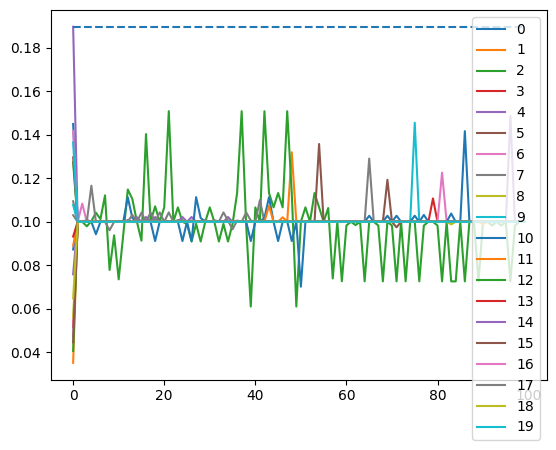

In [17]:
history.plot()
plt.plot(global_best_history,'--')
plt.show()

In [18]:
y_pred = best_model(validation_set.data)
tmp = [torch.argmax(y_pred[i]) for i in range(len(y_pred))]

print(metrics.classification_report(validation_set.targets.detach().numpy(),tmp,target_names=classes,zero_division=0))

              precision    recall  f1-score   support

 T-shirt/top       0.09      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.23      0.65      0.34      1000
       Dress       0.08      0.20      0.11      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.35      0.04      0.08      1000
       Shirt       0.14      0.07      0.10      1000
     Sneaker       0.00      0.00      0.00      1000
         Bag       0.34      0.28      0.31      1000
  Ankle Boot       0.22      0.68      0.34      1000

    accuracy                           0.19     10000
   macro avg       0.15      0.19      0.13     10000
weighted avg       0.15      0.19      0.13     10000



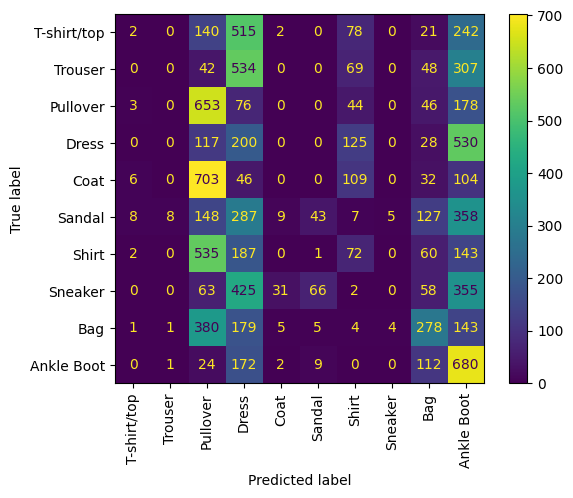

In [19]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(validation_set.targets.detach().numpy(),tmp),display_labels = classes).plot()
plt.xticks(rotation = 90)
plt.show()

### PPSO with another function

In [20]:
from math import tanh

def inertia_function(iteration,max_iter=100,start_theta=0.3,end_theta=1):
  return end_theta + (start_theta-end_theta)*(max_iter-iteration-1)/(iteration+1)

In [21]:
best_model,history,global_best_history = train(
    model=model,
    metric=Accuracy(task="multiclass", num_classes=len(classes)),
    data=training_set.data,
    labels=training_set.targets,
    iterations=100,n_particles=20,alpha=4,beta=4,minim=False,theta_function=inertia_function)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


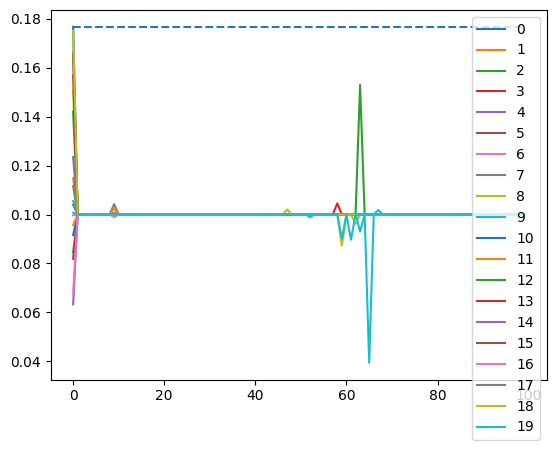

In [22]:
history.plot()
plt.plot(global_best_history,'--')
plt.show()

In [23]:
y_pred = best_model(validation_set.data)
tmp = [torch.argmax(y_pred[i]) for i in range(len(y_pred))]

print(metrics.classification_report(validation_set.targets.detach().numpy(),tmp,target_names=classes,zero_division=0))

              precision    recall  f1-score   support

 T-shirt/top       0.13      0.92      0.23      1000
     Trouser       0.02      0.00      0.00      1000
    Pullover       0.33      0.00      0.01      1000
       Dress       0.13      0.09      0.11      1000
        Coat       0.01      0.00      0.00      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.46      0.78      0.58      1000
         Bag       0.11      0.01      0.02      1000
  Ankle Boot       0.00      0.00      0.00      1000

    accuracy                           0.18     10000
   macro avg       0.12      0.18      0.09     10000
weighted avg       0.12      0.18      0.09     10000



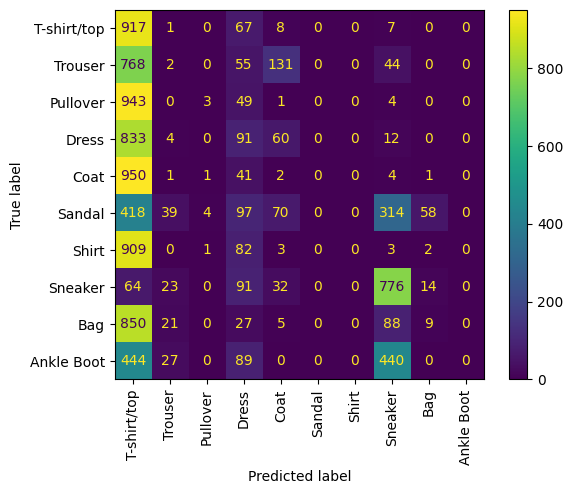

In [24]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(validation_set.targets.detach().numpy(),tmp),display_labels = classes).plot()
plt.xticks(rotation = 90)
plt.show()

## Testing on tabular data

In [37]:
#Train on MNIST
training_set_mnist = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set_mnist = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
#to normal

training_set_mnist.data = training_set_mnist.data.type(torch.float32)
validation_set_mnist.data = validation_set_mnist.data.type(torch.float32)

In [32]:
#mnist model
model_mnist = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,128,dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(128,64,dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(64,10,dtype=torch.float32),
    nn.Softmax(1)
)

best_model_mnist,history_mnist,global_best_history_mnist = train(
    model=model_mnist,
    metric=Accuracy(task="multiclass", num_classes=10),
    data=training_set_mnist.data,
    labels=training_set_mnist.targets,
    iterations=100,n_particles=20,alpha=4,beta=4,minim=False
    )

100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


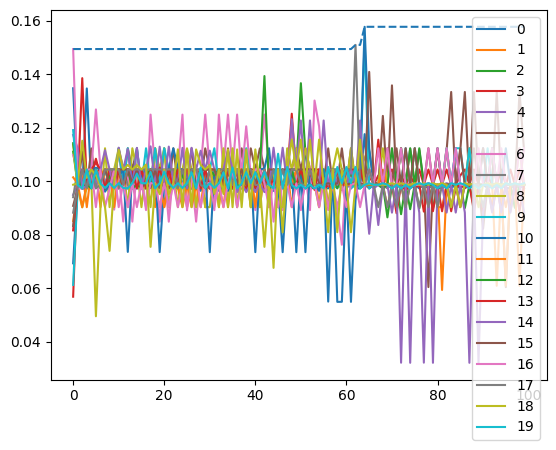

In [35]:
history_mnist.plot()
plt.plot(global_best_history_mnist,'--')
plt.show()

In [38]:
#Print mnist metrics
y_pred = best_model_mnist(validation_set_mnist.data)
tmp = [torch.argmax(y_pred[i]) for i in range(len(y_pred))]
print(metrics.classification_report(validation_set_mnist.targets.detach().numpy(),tmp,zero_division=0))


              precision    recall  f1-score   support

           0       0.18      0.80      0.29       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.14      0.75      0.23      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.16     10000
   macro avg       0.03      0.16      0.05     10000
weighted avg       0.03      0.16      0.05     10000



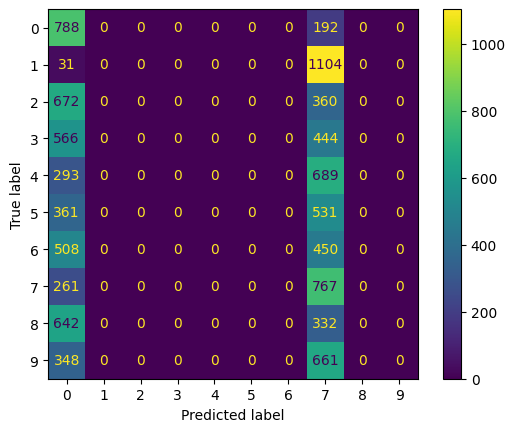

In [39]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(validation_set_mnist.targets.detach().numpy(),tmp)).plot()

In [42]:
#train on iris
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#to float32
X_train = torch.tensor(X_train).type(torch.float32)
X_test = torch.tensor(X_test).type(torch.float32)
y_train = torch.tensor(y_train).type(torch.int64)
y_test = torch.tensor(y_test).type(torch.int64)

In [43]:
model_iris = nn.Sequential(
    nn.Linear(4,128,dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(128,64,dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(64,3,dtype=torch.float32),
    nn.Softmax(1)
)

best_model_iris,history_iris,global_best_history_iris = train(
    model=model_iris,
    metric=Accuracy(task="multiclass", num_classes=3),
    data=torch.tensor(X_train),
    labels=torch.tensor(y_train),
    iterations=100,n_particles=20,alpha=4,beta=4,minim=False
)

/tmp/ipykernel_66779/1334866706.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data=torch.tensor(X_train),
/tmp/ipykernel_66779/1334866706.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(y_train),
  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 50.48it/s]


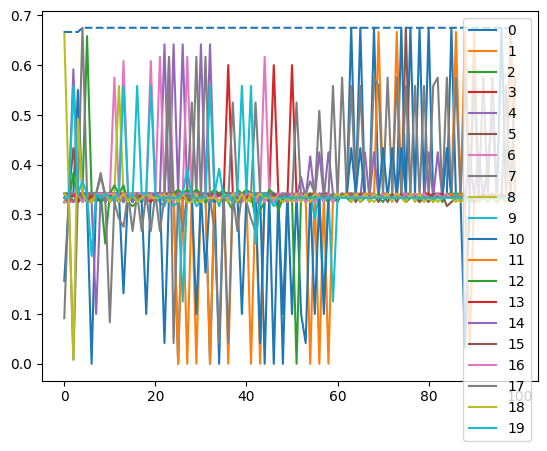

In [44]:
history_iris.plot()
plt.plot(global_best_history_iris,'--')
plt.show()

In [45]:
y_pred = best_model_iris(X_test)
tmp = [torch.argmax(y_pred[i]) for i in range(len(y_pred))]
print(metrics.classification_report(y_test.detach().numpy(),tmp,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.45      1.00      0.62         9
           2       0.00      0.00      0.00        11

    accuracy                           0.63        30
   macro avg       0.48      0.67      0.54        30
weighted avg       0.47      0.63      0.52        30



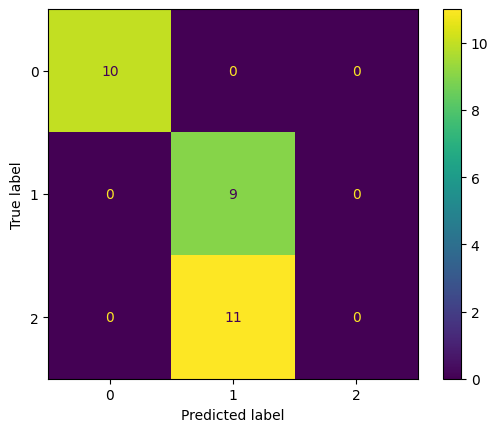

In [46]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test.detach().numpy(),tmp)).plot()